In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import pyccl
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import math
import os

import sys
sys.path.append("./simulation_code/")
from simulate_des_maps import *

from coefficient import * 

## 4 cells for Joe to run:

* each simulation + calculation iteration takes 2-3 min
    * total run time ~ 2.5 * (itr + b) min
    
    
* **itr** is the number of iterations for fixed values (we settled on 100 for now)
* **b** is the number of points along the line perpendicular to the likelihood

In [ ]:
%time coefficient(thr_ct=10, smoothing=20, nside=256, itr=100, b=10)

In [ ]:
%time coefficient(thr_ct=10, smoothing=20, nside=512, itr=100, b=10)

In [ ]:
%time coefficient(thr_ct=10, smoothing=20, nside=1024, itr=100, b=10)

In [ ]:
%time coefficient(thr_ct=10, smoothing=20, nside=2048, itr=100, b=10)

---

Nisha test:

In [4]:
%time coefficient(thr_ct=10, smoothing=10, nside=256, itr=3, b=10)

0
1
2
0
1
2
3
4
5
6
7
8
9
0.43 hrs
CPU times: user 30min 15s, sys: 17 s, total: 30min 32s
Wall time: 33min 30s


---

In [3]:
## load saved data from coefficient file

# total number of pixels in the image
thr_ct = 10
nside = 256
smoothing=5

output_path = os.path.join(os.getcwd(), '2_Maps_Output')

# parent folder for input variable combination
path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')

c = np.loadtxt(os.path.join(path,'c.out'))

# unable to load the maps - too much for my computer to handle
#c_map = np.loadtxt(os.path.join(path,'c_map.out'))
#l_map = np.loadtxt(os.path.join(path,'l_map.out'))

v_all_fixed = np.loadtxt(os.path.join(path, 'V_all_fixed.out'))
V_all = np.loadtxt(os.path.join(path, 'v_all_changing'))

'''
fixed_path = os.path.join(path, 'fixed')
v_fixed = np.loadtxt(os.path.join(fixed_path,'v.out'))
v0_fixed = np.loadtxt(os.path.join(fixed_path,'v0.out'))
v1_fixed = np.loadtxt(os.path.join(fixed_path,'v1.out'))
v2_fixed = np.loadtxt(os.path.join(fixed_path,'v2.out'))

changing_path = os.path.join(path, 'changing')
v = np.loadtxt(os.path.join(changing_path,'v.out'))
v_all = np.loadtxt(os.path.join(changing_path,'v_all.out'))'''

"\nfixed_path = os.path.join(path, 'fixed')\nv_fixed = np.loadtxt(os.path.join(fixed_path,'v.out'))\nv0_fixed = np.loadtxt(os.path.join(fixed_path,'v0.out'))\nv1_fixed = np.loadtxt(os.path.join(fixed_path,'v1.out'))\nv2_fixed = np.loadtxt(os.path.join(fixed_path,'v2.out'))\n\nchanging_path = os.path.join(path, 'changing')\nv = np.loadtxt(os.path.join(changing_path,'v.out'))\nv_all = np.loadtxt(os.path.join(changing_path,'v_all.out'))"

---

# Individual Steps 

### 1. Calculate Mean and Covariance

In [50]:
## Simulation Variables
thr_ct = 10                    # threshold count
nside = 256                    # number of pixels on each side of the map
smoothing=5                    # map scale
N = 12*nside*nside             # total number of pixels

## Analysis Variables
itr = 5                        # number of iterations - rerun this bit 100 times (rerun with 270ish if there's time)
map_len = 9                    # sum of the number of lensing and clustering redshift bins
array_len = map_len*thr_ct*3   # length of covariance array - multiply by 3 for 3 MFs
b=10                           # number of points along likelihood perpendicular line

In [51]:
# Fixed map run with iteration count
v_all_fixed = np.zeros((itr,array_len)) 
for i in range(itr):
    %time clustering_maps, lensing_maps = simulate_des_maps(0.3, 0.8, smoothing, nside)
    %time v_fixed, v0_fixed, v1_fixed, v2_fixed = calc_mf_2maps(clustering_maps,lensing_maps,thr_ct,N)
    v_all_fixed[i] = np.concatenate((v0_fixed.flatten(),v1_fixed.flatten(),v2_fixed.flatten()))

v_all_fixed.shape

CPU times: user 1min, sys: 1.3 s, total: 1min 1s
Wall time: 1min 46s
CPU times: user 1min 23s, sys: 427 ms, total: 1min 23s
Wall time: 54.5 s
CPU times: user 1min, sys: 641 ms, total: 1min
Wall time: 1min 39s
CPU times: user 1min 19s, sys: 341 ms, total: 1min 19s
Wall time: 52.3 s
CPU times: user 1min 1s, sys: 437 ms, total: 1min 1s
Wall time: 1min 44s
CPU times: user 1min 18s, sys: 329 ms, total: 1min 19s
Wall time: 51.9 s
CPU times: user 1min 1s, sys: 446 ms, total: 1min 2s
Wall time: 1min 36s
CPU times: user 1min 19s, sys: 461 ms, total: 1min 20s
Wall time: 52.5 s
CPU times: user 1min 1s, sys: 473 ms, total: 1min 2s
Wall time: 1min 36s
CPU times: user 1min 17s, sys: 375 ms, total: 1min 18s
Wall time: 51 s


(5, 270)

(270, 270)


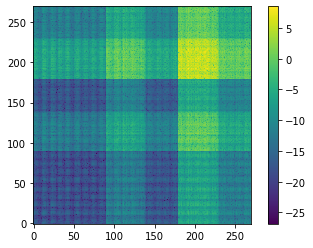

In [52]:
# covariance - should be 270x270
cov = np.cov((v_all_fixed.transpose()))
print(cov.shape)
plt.imshow(log(abs(cov)),origin='lower')
plt.colorbar();

In [53]:
# stack 100 iteration fixed variable versions of V0,V1,V2
v_all_mean = np.zeros(array_len)

for i in range(array_len):
    v_all_mean[i] = mean(v_all_fixed[:,i])
    
# mean array used in likelihood calculation    
v_all_mean.shape

(270,)

### 2. Run simulation for $\Omega_m$ and $\sigma_8$ values along likelihood perpendicular line, Calculate and Plot MFs

In [67]:
# points (get constants from plotting notebook)
omega_m = np.linspace(0.2,0.4,b)
sigma_8 = 0.8989639361571576*omega_m + 0.5303108191528527

S_8 = np.zeros(b)
for i in range(b):
    S_8[i] = sigma_8[i] * (omega_m[i]/0.3)**0.5329788249790618  

In [21]:
tic = time.perf_counter()

V_all = np.zeros((b,array_len))
c_map = np.zeros((b,len(clustering_maps),N)) 
l_map = np.zeros((b,len(lensing_maps),N))
    
for i in range(b):
    c_map[i], l_map[i] = simulate_des_maps(omega_m[i], sigma_8[i], smoothing, nside)
    v, v0, v1, v2 = calc_mf_2maps(c_map[i],l_map[i],thr_ct,N)
    V_all[i] = np.concatenate((v0.flatten(),v1.flatten(),v2.flatten()))
    print(i)
    
toc = time.perf_counter()
print(round((toc - tic)/3600,2),'hrs')

V_all.shape

0
1
2
3
4
5
6
7
8
9
0.58 hrs


(10, 270)

### 3. Calculate Constraining Power

In [68]:
# singular matrix workaround - do we only want positive covariance values or just not = 0?
good = cov.diagonal() > 0
cov2 = cov[good][:, good]

# calculate the likelihood          
L = np.zeros(b)

try:
    inv_cov = np.linalg.inv(cov)
    for i in range(b):
        L[i] = -0.5 * (V_all[i] - v_all_mean) @ inv_cov @ (V_all[i] - v_all_mean)
except:
    inv_cov2 = np.linalg.inv(cov2)
    for i in range(b):
        d = (V_all[i] - v_all_mean)[good]
        L[i] = -0.5 * d @ inv_cov2 @ d
#finally:
#    print('sad')

L

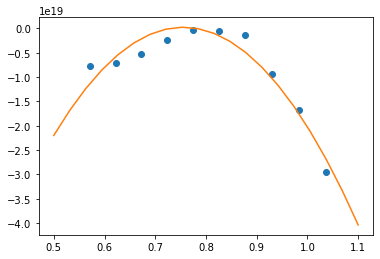

In [69]:
# fit a quadratic curve to L(S_8)

coefficient = np.polyfit(S_8,L,2)
poly = np.poly1d(coefficient)     
new_x = np.linspace(0.5,1.1,20)
new_y = poly(new_x)
plt.plot(S_8, L, "o", new_x, new_y);

In [62]:
constraining_power = sqrt(-1 / (2*coefficient[0]))
constraining_power

3.8254900074825694e-11

In [14]:
# save data

# parent directory
output_path = os.path.join(os.getcwd(), '2_Maps_Output')
    
# path for given inputs
path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')

try:
    os.mkdir(path) 
except:
    pass

#c = np.array((thr_ct,smoothing,nside,constraining_power))
#np.savetxt(os.path.join(path, 'c.out'),c)

# reformat maps into 2D to be able to save them
C_map = c_map.reshape((b*len(clustering_maps),N))
L_map = l_map.reshape((b*len(lensing_maps),N))
np.save(os.path.join(path, 'c_map'),C_map)
np.save(os.path.join(path, 'l_map'),L_map)

np.savetxt(os.path.join(path, 'V_all_fixed.out'),v_all_fixed)
np.savetxt(os.path.join(path, 'v_all_changing'),V_all)

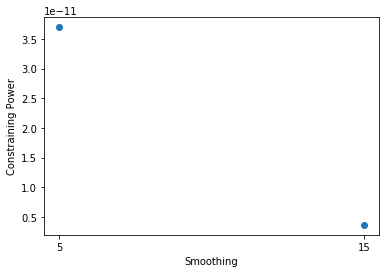

In [34]:
# plot smoothing vs. constraining power
smoothing_array = [5,15]#,15]#np.linspace(5,60,12)
thr_ct = 10
nside = 256
cp = np.zeros(len(smoothing_array))

# parent directory
output_path = os.path.join(os.getcwd(), '2_Maps_Output')
    
#for i in smoothing_array:
for i,smoothing in enumerate(smoothing_array):
    path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')
    output = np.loadtxt(os.path.join(path, 'c.out'))
    cp[i] = output[3]
    
plt.plot(smoothing_array,cp,'o')
plt.xlabel('Smoothing')
plt.xticks(smoothing_array)
plt.ylabel('Constraining Power');

In [14]:
os.mkdir('2_Maps_Output')

FileExistsError: [Errno 17] File exists: '2_Maps_Output'

In [14]:
# save data by threshold range, nside, and smoothing
'''
output_path = os.path.join(os.getcwd(), '2_Maps_Output')

# parent folder for input variable combination
path = os.path.join(output_path, f't{thr_ct}_n{nside}_s{smoothing}')

try:
    os.mkdir(path) 
except:
    pass

np.savetxt(os.path.join(path, 'c_map.out'),clustering_maps)
np.savetxt(os.path.join(path, 'l_map.out'),lensing_maps)


np.savetxt(os.path.join(path, 'c.out'),c)


# save fixed parameter data that is used to find the mean and covariance
fixed_path = os.path.join(path, 'fixed')

try:
    os.mkdir(fixed_path)
except:
    pass

np.savetxt(os.path.join(fixed_path, 'v.out'),v_fixed)
np.savetxt(os.path.join(fixed_path, 'v0.out'),v0_fixed)
np.savetxt(os.path.join(fixed_path, 'v1.out'),v1_fixed)
np.savetxt(os.path.join(fixed_path, 'v2.out'),v2_fixed)


# save changing parameter data that is used to find the likelihood
changing_path = os.path.join(path, 'changing')

try:
    os.mkdir(changing_path)
except:
    pass

np.savetxt(os.path.join(changing_path, 'v.out'),v)
np.savetxt(os.path.join(changing_path, 'v_all.out'),v_all)
'''

"\n\nnp.savetxt(os.path.join(path, 'c.out'),c)\n\n\n# save fixed parameter data that is used to find the mean and covariance\nfixed_path = os.path.join(path, 'fixed')\n\ntry:\n    os.mkdir(fixed_path)\nexcept:\n    pass\n\nnp.savetxt(os.path.join(fixed_path, 'v.out'),v_fixed)\nnp.savetxt(os.path.join(fixed_path, 'v0.out'),v0_fixed)\nnp.savetxt(os.path.join(fixed_path, 'v1.out'),v1_fixed)\nnp.savetxt(os.path.join(fixed_path, 'v2.out'),v2_fixed)\n\n\n# save changing parameter data that is used to find the likelihood\nchanging_path = os.path.join(path, 'changing')\n\ntry:\n    os.mkdir(changing_path)\nexcept:\n    pass\n\nnp.savetxt(os.path.join(changing_path, 'v.out'),v)\nnp.savetxt(os.path.join(changing_path, 'v_all.out'),v_all)\n"

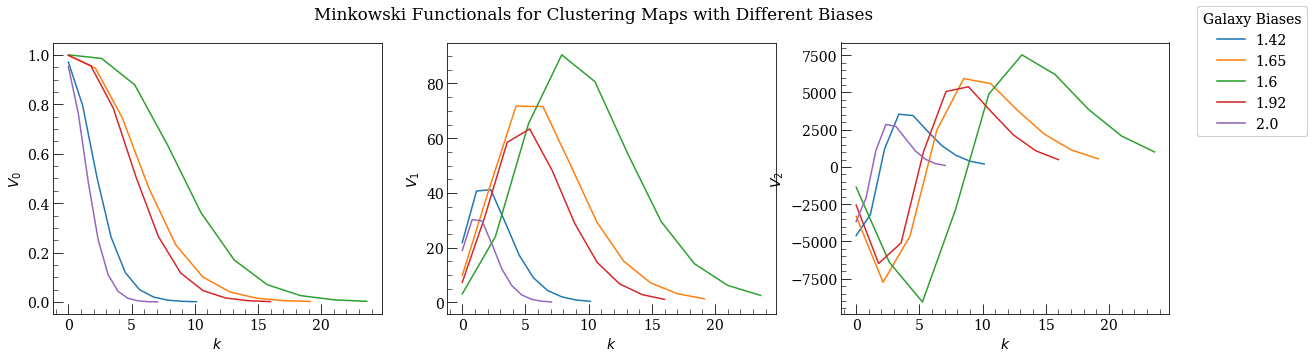

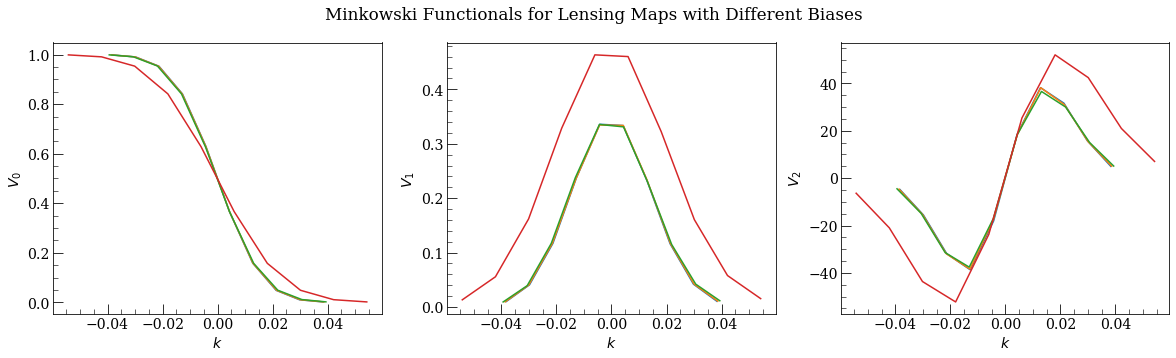

In [8]:
# plot MFs for clustering and lensing maps
from matplotlib import rcParams
rcParams['xtick.direction'] = 'in'
rcParams['xtick.major.size'] = 10
rcParams['xtick.minor.size'] = 5
rcParams['xtick.minor.visible'] = True
rcParams['ytick.direction'] = 'in'
rcParams['ytick.minor.size'] = 5
rcParams['ytick.minor.visible'] = True
rcParams['ytick.major.size'] = 10
rcParams['font.family'] = 'serif'
#rcParams['font.serif'] = ['Times New Roman']
rcParams['font.size'] = 14

fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Clustering Maps with Different Biases'))
for i in range(0,5):
    ax1.plot(v_fixed[i],v0_fixed[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_fixed[i],v1_fixed[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_fixed[i],v2_fixed[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    fig.legend([1.42, 1.65, 1.60, 1.92, 2.00],title = 'Galaxy Biases') 
    
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))
fig.suptitle(('Minkowski Functionals for Lensing Maps with Different Biases'))
for i in range(5,9):
    ax1.plot(v_fixed[i],v0_fixed[i])
    ax1.set_xlabel('$k$')
    ax1.set_ylabel('$V_0$')
    ax2.plot(v_fixed[i],v1_fixed[i])
    ax2.set_xlabel('$k$')
    ax2.set_ylabel('$V_1$')
    ax3.plot(v_fixed[i],v2_fixed[i])
    ax3.set_xlabel('$k$')
    ax3.set_ylabel('$V_2$')
    # not sure how to label redshift bins here